In [17]:
!gdown --folder "https://drive.google.com/drive/folders/1KbSJ1txVdeLkaD8zNhFrF6hQaAQZ1_if?usp=sharing" -O high_quality_robot_aruco

Retrieving folder contents
Processing file 1kLH2QwxK7H4PZMUG1IBru4MGnSujJai1 Camera_00_4K_frame_002.png
Processing file 1AV01GKmcvS2UAHIkAVK16pED68PrXTvr Camera_01_4K_frame_002.png
Processing file 15k2tvH35-PpI_5rQr02K6A8QFuPbc7g4 Camera_02_4K_frame_002.png
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1kLH2QwxK7H4PZMUG1IBru4MGnSujJai1
To: /home/oleg.serikov/cv-for-dog/high_quality_robot_aruco/Camera_00_4K_frame_002.png
100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 73.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AV01GKmcvS2UAHIkAVK16pED68PrXTvr
To: /home/oleg.serikov/cv-for-dog/high_quality_robot_aruco/Camera_01_4K_frame_002.png
100%|███████████████████████████████████████| 10.7M/10.7M [00:00<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=15k2tvH35-PpI_5rQr02K6A8QFuPbc7g4
To: /home/oleg.serikov/cv-for-dog/high_qualit

#### object detection: get bounding boxes for every object

In [18]:
import base64
import mimetypes
import os

from google import genai
from google.genai import types


def save_binary_file(file_name, data):
    with open(file_name, "wb") as f:
        f.write(data)
    print(f"File saved to to: {file_name}")

In [ ]:
import cv2
import numpy as np

object2color = {"robodog": "blue", "human / mannequin": "yellow", "trash bin": "green"}
PROMPT = (
    """
You receive an image.
You have to modify its regions while keeping most of the image intact.
Most precisely you have to:
"""
    + "\n".join(
        f"* color {object_name} with {color} color"
        for object_name, color in object2color.items()
    )
    + """

Ensure to never add new objects. 
In particular, there is maximum one robodog on the image, and in the original image it's greyish.

Answer with the resulting image only, no conversation needed.
"""
)
print(PROMPT)

client = genai.Client(api_key=os.environ.get("GEMINI_API_KEY"))
model = "gemini-2.5-flash-image-preview"
generate_content_config = types.GenerateContentConfig(
    response_modalities=["IMAGE"], temperature=1
)


def color_code_image(src_image_path, tgt_image_path):
    with open(src_image_path, "rb") as src_image:
        base64_src_image = base64.b64encode(src_image.read()).decode("utf-8")
    contents = [
        types.Content(
            role="user",
            parts=[types.Part.from_bytes(mime_type="image/png", data=base64_src_image)],
        ),
        types.Content(role="user", parts=[types.Part.from_text(text=PROMPT)]),
    ]

    file_index = 0
    file_path2buffer = dict()
    for chunk in client.models.generate_content_stream(
        model=model, contents=contents, config=generate_content_config
    ):
        if (
            chunk.candidates is None
            or chunk.candidates[0].content is None
            or chunk.candidates[0].content.parts is None
        ):
            continue
        if (
            chunk.candidates[0].content.parts[0].inline_data
            and chunk.candidates[0].content.parts[0].inline_data.data
        ):
            file_name = f"ENTER_FILE_NAME_{file_index}"
            file_index += 1
            inline_data = chunk.candidates[0].content.parts[0].inline_data
            data_buffer = inline_data.data
            file_extension = mimetypes.guess_extension(inline_data.mime_type)
            file_path2buffer[f"{file_name}{file_extension}"] = data_buffer
        else:
            print(chunk.text)

    if len(file_path2buffer) == 1:
        save_binary_file(tgt_image_path, list(file_path2buffer.values())[0])
    else:
        for file_name, data_buffer in file_path2buffer.items():
            save_binary_file(file_name, data_buffer)


def get_color_code_image_retries(src_image_path, tgt_image_path, retries=3):
    for retry_ix in range(retries):
        assert tgt_image_path.count(".") == 1, (
            "There should be only one dot (.) in the filename, sorry"
        )
        retry_fname = tgt_image_path.replace(".", f"_retry_{retry_ix}.")
        color_code_image(src_image_path, retry_fname)


def get_colored_bboxes(src_image1, src_image2, draw_result=False, min_area=200):
    """
    Returns bboxes for colored highlights seen in src_image2 (aligned onto src_image1):
      {
        "green_bbox": {"x":..., "y":..., "w":..., "h":...} or None,
        "red_bbox":   {...} or None,
        "yellow_bbox":{...} or None,
        "blue_bbox":  {...} or None
      }
    min_area prunes tiny specks (pixels).
    """
    im1 = cv2.imread(src_image1)
    im2 = cv2.imread(src_image2)
    if im1 is None or im2 is None:
        raise ValueError("Could not read one or both images.")

    # ---------- Step 1: align im2 -> im1 ----------
    gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(5000)
    k1, d1 = orb.detectAndCompute(gray1, None)
    k2, d2 = orb.detectAndCompute(gray2, None)
    if d1 is None or d2 is None:
        raise RuntimeError("Failed to compute ORB descriptors.")

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(d1, d2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    if len(good) < 12:
        raise RuntimeError("Not enough matches to align images.")

    pts1 = np.float32([k1[m.queryIdx].pt for m in good])
    pts2 = np.float32([k2[m.trainIdx].pt for m in good])
    H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC, 3.0)

    h, w = im1.shape[:2]
    im2_aligned = cv2.warpPerspective(im2, H, (w, h))

    # ---------- Step 2: chroma difference mask (where color changed) ----------
    lab1 = cv2.cvtColor(im1, cv2.COLOR_BGR2LAB)
    lab2 = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2LAB)
    _, a1, b1 = cv2.split(lab1)
    _, a2, b2 = cv2.split(lab2)

    ab1 = np.dstack([a1.astype(np.int16), b1.astype(np.int16)])
    ab2 = np.dstack([a2.astype(np.int16), b2.astype(np.int16)])
    diff = np.sqrt(((ab1 - ab2) ** 2).sum(axis=2)).astype(np.float32)

    diff_blur = cv2.GaussianBlur(diff, (5, 5), 0)
    diff_norm = cv2.normalize(diff_blur, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, change_mask = cv2.threshold(
        diff_norm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Clean the mask
    kernel = np.ones((5, 5), np.uint8)
    change_mask = cv2.morphologyEx(change_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    change_mask = cv2.morphologyEx(change_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # ---------- Step 3: classify changed pixels by color in HSV ----------
    hsv2 = cv2.cvtColor(im2_aligned, cv2.COLOR_BGR2HSV)

    # Reasonable default HSV ranges for vivid highlights (tune if needed).
    # H in OpenCV is [0,179], S,V in [0,255].
    color_ranges = {
        "green": [
            (np.array([35, 60, 60]), np.array([85, 255, 255]))
        ],  # ~ lime to green-cyan
        "yellow": [
            (np.array([20, 60, 60]), np.array([35, 255, 255]))
        ],  # gold to yellow
        "blue": [
            (np.array([90, 60, 60]), np.array([130, 255, 255]))
        ],  # sky to deep blue
        # Red wraps around hue=0, so two intervals:
        "red": [
            (np.array([0, 60, 60]), np.array([10, 255, 255])),
            (np.array([170, 60, 60]), np.array([179, 255, 255])),
        ],
    }

    def biggest_bbox_from_mask(mask, min_area_px):
        num_labels, _, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        if num_labels <= 1:
            return None
        # Skip label 0 (background); keep the largest area that exceeds min_area
        best = None
        best_area = 0
        for lbl in range(1, num_labels):
            x, y, w0, h0, area = stats[lbl]
            if area >= min_area_px and area > best_area:
                best_area = area
                best = (x, y, w0, h0)
        if best is None:
            return None
        x, y, w0, h0 = best
        return {"x": int(x), "y": int(y), "w": int(w0), "h": int(h0)}

    results = {
        "green_bbox": None,
        "red_bbox": None,
        "yellow_bbox": None,
        "blue_bbox": None,
    }
    draw = im1.copy()

    for cname, ranges in color_ranges.items():
        # Mask of pixels that changed *and* fall within the HSV color for this highlight
        color_mask = np.zeros(change_mask.shape, dtype=np.uint8)
        for lo, hi in ranges:
            color_mask |= cv2.inRange(hsv2, lo, hi)

        # Only consider changed pixels
        candidate = cv2.bitwise_and(color_mask, change_mask)

        # Clean up & fill small holes specific to this color
        candidate = cv2.morphologyEx(
            candidate, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1
        )
        candidate = cv2.morphologyEx(
            candidate, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=1
        )

        bbox = biggest_bbox_from_mask(candidate, min_area)
        key = f"{cname}_bbox"
        results[key] = bbox

        if draw_result and bbox is not None:
            x, y, w0, h0 = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
            # color-coded rectangle (BGR)
            color_bgr = {
                "green": (0, 255, 0),
                "red": (0, 0, 255),
                "yellow": (0, 255, 255),
                "blue": (255, 0, 0),
            }[cname]
            cv2.rectangle(draw, (x, y), (x + w0, y + h0), color_bgr, 3)

    if draw_result:
        cv2.imwrite(src_image1.replace(".png", "_colored_bboxes.png"), draw)

    return results


def detect_objects(fname):
    result_fname = fname.replace(".png", "_color-coded.png")
    color_code_image(fname, result_fname)
    color_coding = get_colored_bboxes(fname, result_fname, draw_result=True)
    object_bboxes = dict()
    for obj, color in object2color.items():
        color_key = f"{color}_bbox"
        if color_coding.get(color_key) is None:
            continue
        object_bboxes[obj] = color_coding[color_key]
    return object_bboxes


You receive an image.
You have to modify its regions while keeping most of the image intact.
Most precisely you have to:
* color robodog with blue color
* color human / mannequin with yellow color
* color trash bin with green color

Ensure to never add new objects. 
In particular, there is maximum one robodog on the image, and in the original image it's greyish.

Answer with the resulting image only, no conversation needed.



In [20]:
cam_views = !ls -1 high_quality_robot_aruco/* | grep -v colored | grep -v bbox | grep -v color-coded

In [5]:
cam_views_results = {fn: detect_objects(fn) for fn in cam_views}

File saved to to: high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded.png
File saved to to: high_quality_robot_aruco/Camera_01_4K_frame_002_color-coded.png
File saved to to: high_quality_robot_aruco/Camera_02_4K_frame_002_color-coded.png


In [ ]:
def calculate_iou(boxA, boxB):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.
    Each box is a dictionary: {"x": int, "y": int, "w": int, "h": int}
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA["x"], boxB["x"])
    yA = max(boxA["y"], boxB["y"])
    xB = min(boxA["x"] + boxA["w"], boxB["x"] + boxB["w"])
    yB = min(boxA["y"] + boxA["h"], boxB["y"] + boxB["h"])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    # Compute the area of both bounding boxes
    boxAArea = boxA["w"] * boxA["h"]
    boxBArea = boxB["w"] * boxB["h"]

    # Compute the union area, avoiding division by zero
    unionArea = float(boxAArea + boxBArea - interArea)
    if unionArea == 0:
        return 0.0

    # Return the IoU value
    return interArea / unionArea


def calculate_inclusion_overlap(boxA, boxB):
    """
    Calculates the ratio of the intersection area to the area of the smaller box.
    This checks for containment rather than just overlap.
    Each box is a dictionary: {"x": int, "y": int, "w": int, "h": int}
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA["x"], boxB["x"])
    yA = max(boxA["y"], boxB["y"])
    xB = min(boxA["x"] + boxA["w"], boxB["x"] + boxB["w"])
    yB = min(boxA["y"] + boxA["h"], boxB["y"] + boxB["h"])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    # Compute the area of both bounding boxes
    boxAArea = boxA["w"] * boxA["h"]
    boxBArea = boxB["w"] * boxB["h"]

    # Get the area of the smaller of the two boxes
    smaller_area = min(boxAArea, boxBArea)
    if smaller_area == 0:
        return 0.0

    # Return the ratio of intersection relative to the smaller box
    return interArea / float(smaller_area)


def draw_final_result(src_image_path, object_bboxes, output_suffix="_final_detection"):
    """
    Draws the final, validated bounding boxes on the source image and saves it.
    """
    img = cv2.imread(src_image_path)
    if img is None:
        print(f"Error: Could not read source image at {src_image_path}")
        return

    # BGR colors for drawing
    color_map_bgr = {
        "green": (0, 255, 0),
        "yellow": (0, 255, 255),
        "blue": (255, 0, 0),
        "red": (0, 0, 255),
    }

    for obj, bbox in object_bboxes.items():
        color_name = object2color.get(obj)
        if color_name and bbox:
            color = color_map_bgr.get(color_name, (255, 255, 255))  # Default to white
            x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 3)
            cv2.putText(img, obj, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    base, ext = os.path.splitext(src_image_path)
    output_path = f"{base}{output_suffix}{ext}"
    cv2.imwrite(output_path, img)
    print(f"✅ Final detection result saved to: {output_path}")


# --- New Main Detection Function ---
def detect_objects_robust(
    fname, retries=5, consistency_threshold=0.6, overlap_threshold=0.8
):
    """
    Performs robust object detection with the new inclusion-based overlap logic.
    """
    print(f"🚀 Starting robust detection for '{fname}' with {retries} retries...")

    # Step 1: Generate or load color-coded images (No changes here)
    base_result_fname = fname.replace(".", "_color-coded.")
    retry_fnames = []
    for i in range(retries):
        retry_fname = base_result_fname.replace(".", f"_retry_{i}.")
        retry_fnames.append(retry_fname)

        if not os.path.exists(retry_fname):
            print(f"🎨 Attempt {i + 1}/{retries}: Generating '{retry_fname}'...")
            try:
                color_code_image(fname, retry_fname)
            except Exception as e:
                print(f"API call failed for attempt {i + 1}: {e}")
        else:
            print(f"Found existing file for attempt {i + 1}: '{retry_fname}'")

    # Step 2: Collect all bounding boxes from all retries (No changes here)
    all_bboxes_by_color = {color: [] for color in object2color.values()}
    for i, retry_fname in enumerate(retry_fnames):
        if not os.path.exists(retry_fname):
            print(f"Skipping failed generation: {retry_fname}")
            for color in all_bboxes_by_color:
                all_bboxes_by_color[color].append(None)
            continue

        print(f"Processing bboxes for attempt {i + 1}...")
        try:
            color_coding = get_colored_bboxes(fname, retry_fname)
            for color in all_bboxes_by_color:
                all_bboxes_by_color[color].append(color_coding.get(f"{color}_bbox"))
        except (ValueError, RuntimeError) as e:
            print(f"Could not process bboxes for '{retry_fname}': {e}")
            for color in all_bboxes_by_color:
                all_bboxes_by_color[color].append(None)

    # Step 3: Find consistent bounding boxes through clustering
    final_bboxes_by_color = {}
    min_detections_needed = int(retries * consistency_threshold)
    print(
        f"\nFiltering clusters. A bbox must appear in at least {min_detections_needed} images."
    )

    for color, bboxes_list in all_bboxes_by_color.items():
        valid_bboxes = [b for b in bboxes_list if b is not None]
        if not valid_bboxes:
            continue

        clusters = []
        for box in valid_bboxes:
            placed = False
            for cluster in clusters:
                # --- MODIFIED LOGIC ---
                # Use the new overlap function and threshold
                if calculate_inclusion_overlap(box, cluster[0]) >= overlap_threshold:
                    # ----------------------
                    cluster.append(box)
                    placed = True
                    break
            if not placed:
                clusters.append([box])

        if not clusters:
            continue

        clusters.sort(key=len, reverse=True)
        best_cluster = clusters[0]

        obj_name = [k for k, v in object2color.items() if v == color][0]
        print(
            f"Found cluster for '{obj_name}' ({color}) with {len(best_cluster)} members."
        )

        if len(best_cluster) >= min_detections_needed:
            avg_x = int(sum(b["x"] for b in best_cluster) / len(best_cluster))
            avg_y = int(sum(b["y"] for b in best_cluster) / len(best_cluster))
            avg_w = int(sum(b["w"] for b in best_cluster) / len(best_cluster))
            avg_h = int(sum(b["h"] for b in best_cluster) / len(best_cluster))

            final_bboxes_by_color[color] = {
                "x": avg_x,
                "y": avg_y,
                "w": avg_w,
                "h": avg_h,
            }
            print(
                f"  -> SUCCESS: Cluster is consistent. Averaged bbox: {final_bboxes_by_color[color]}"
            )
        else:
            print("  -> FAIL: Cluster is not consistent. Discarding.")

    # Step 4: Map final bboxes and draw result (No changes here)
    final_object_bboxes = {}
    for obj, color in object2color.items():
        if color in final_bboxes_by_color:
            final_object_bboxes[obj] = final_bboxes_by_color[color]

    draw_final_result(fname, final_object_bboxes)

    return final_object_bboxes

In [ ]:
cam_robust_results = {
    fn: detect_objects_robust(fn, consistency_threshold=0.4) for fn in cam_views
}

🚀 Starting robust detection for 'high_quality_robot_aruco/Camera_00_4K_frame_002.png' with 5 retries...
Found existing file for attempt 1: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_0.png'
Found existing file for attempt 2: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_1.png'
Found existing file for attempt 3: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_2.png'
Found existing file for attempt 4: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_3.png'
Found existing file for attempt 5: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_4.png'
Processing bboxes for attempt 1...
Processing bboxes for attempt 2...
Processing bboxes for attempt 3...
Processing bboxes for attempt 4...
Processing bboxes for attempt 5...

Filtering clusters. A bbox must appear in at least 2 images.
Found cluster for 'robodog' (blue) with 3 members.
  -> SUCCESS: Cluster is consistent. Averaged bbox: {'x': 2346,

### aruco detection: get aruco markers for each object


In [ ]:
# --- Imports ---
import json
import os

from ultralytics import YOLO

try:
    from google.colab.patches import cv2_imshow
except ImportError:
    from cv2 import imshow as cv2_imshow

MODEL_NAME = "yolo11x.pt"  # You can use yolo11m.pt or yolo11s.pt for faster inference
CUP_CLASS_ID = 41  # COCO class ID for 'cup'


def detect_cup_with_yolo(image: np.ndarray, model: YOLO) -> dict | None:
    """
    Detect cup using YOLO model and return bbox and center coordinates
    """
    results = model(image)

    # Find cups in the results
    cup_detections = []
    img_height, img_width = image.shape[:2]

    for result in results:
        if result.boxes is None:
            continue

        for i, cls in enumerate(result.boxes.cls):
            if int(cls.item()) == CUP_CLASS_ID:
                # Get bbox in xyxy format
                xyxy = result.boxes.xyxy[i]
                conf = result.boxes.conf[i].item()

                # Extract coordinates
                x1, y1, x2, y2 = xyxy.tolist()

                # Calculate center
                center_x = (x1 + x2) / 2
                center_y = (y1 + y2) / 2

                cup_detections.append(
                    {
                        "bbox": [x1, y1, x2, y2],  # [xmin, ymin, xmax, ymax]
                        "center": [center_x, center_y],
                        "confidence": conf,
                    }
                )

    if not cup_detections:
        return None

    # Return the cup with highest confidence
    return max(cup_detections, key=lambda x: x["confidence"])


print("Loading YOLO model...")
yolo_model = YOLO(MODEL_NAME)
print(f"YOLO model loaded: {MODEL_NAME}")


# --- ArUco setup ---
aruco_dict_name = "DICT_ARUCO_ORIGINAL"
aruco_dict = cv2.aruco.getPredefinedDictionary(getattr(cv2.aruco, aruco_dict_name))

params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, params)


def detect_func(img):
    return detector.detectMarkers(img)


def process_image(img_path, draw_visual_log=False):
    print(f"\n{'=' * 60}")
    print(f"Processing: {img_path}")
    print("=" * 60)

    image = cv2.imread(img_path)
    if image is None:
        print("  Could not read this image, skipping.")
        return

    img_height, img_width = image.shape[:2]

    fn_result = {
        "markers": {},
        "cup": None,
        "image_dimensions": [img_width, img_height],
    }

    # --- ArUco Detection ---
    corners, ids, rejected = detect_func(image)
    if draw_visual_log:
        output = image.copy()

    if ids is not None and len(ids) > 0:
        if draw_visual_log:
            cv2.aruco.drawDetectedMarkers(output, corners, ids)

        print(f"  ArUco markers: {len(ids)} detected. IDs: {ids.flatten().tolist()}")

        for corner_set, marker_id in zip(corners, ids.flatten(), strict=False):
            # Get the 4 corners of this marker
            pts = corner_set.reshape(-1, 2)
            center = pts.mean(axis=0)

            # Store marker data
            fn_result["markers"][int(marker_id)] = {
                "corners": pts.tolist(),
                "center": center.tolist(),
            }

            # Print marker info
            print(
                f"    Marker {marker_id}: center at ({center[0]:.1f}, {center[1]:.1f})"
            )

            if draw_visual_log:
                # Draw center point
                cv2.circle(output, tuple(center.astype(int)), 5, (0, 255, 0), -1)
    else:
        print("  ArUco markers: None detected")

    # --- YOLO Cup Detection ---
    print("  Detecting cup with YOLO...")
    cup_detection = detect_cup_with_yolo(image, yolo_model)

    if cup_detection:
        # Store cup data
        fn_result["cup"] = cup_detection

        # Extract coordinates
        x1, y1, x2, y2 = cup_detection["bbox"]
        center = cup_detection["center"]
        conf = cup_detection["confidence"]

        print("  Cup detected:")
        print(f"    Confidence: {conf:.2%}")
        print(f"    Center: ({center[0]:.1f}, {center[1]:.1f})")
        print(f"    BBox: [({x1:.1f}, {y1:.1f}), ({x2:.1f}, {y2:.1f})]")

        if draw_visual_log:
            # Draw cup detection on image
            cv2.rectangle(
                output, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3
            )

            # Draw cup center
            cv2.circle(output, (int(center[0]), int(center[1])), 7, (255, 0, 0), -1)

            # Add label
            label = f"Cup ({conf:.2%})"
            cv2.putText(
                output,
                label,
                (int(x1), int(y1) - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 0, 0),
                2,
            )
    else:
        print("  Cup: Not detected")

    # --- GenAI objects detection ---
    print("  Detecting objects with GenAI...")
    object_bboxes = detect_objects_robust(
        img_path, consistency_threshold=0.4, overlap_threshold=0.95
    )
    for obj_name, bbox in object_bboxes.items():
        if bbox is None:
            continue
        print(f"    {obj_name}: bbox: {bbox}")
        print(fn_result["cup"])

        x, y, w, h = bbox["x"], bbox["y"], bbox["w"], bbox["h"]
        x1, y1, x2, y2 = x, y, x + w, y + h
        center = [(x1 + x2) / 2, (y1 + y2) / 2]
        bbox_di = {"bbox": [x1, y1, x2, y2], "center": center, "confidence": 0.95}
        fn_result[obj_name] = bbox_di

    if draw_visual_log:
        # Display annotated image
        cv2_imshow(output)

        # Save annotated image
        out_path = os.path.splitext(img_path)[0] + "_annotated.jpg"
        cv2.imwrite(out_path, output)
        print(f"  Saved: {out_path}")
    return fn_result

Loading YOLO model...
YOLO model loaded: yolo11x.pt


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

CORNER_MARKER_IDS = [0, 1, 6, 5]
TARGET_MARKER_IDS = [37, 38, 39]

WORLD_ANCHOR_POINTS = [
    (0.0, 1.0),
    (1.0, 1.0),
    (1.0, 0.0),
    (0.0, 0.0),
]

corner_labels = ["Top-Left", "Top-Right", "Bottom-Right", "Bottom-Left"]


def auto_detect_corner_order(corner_markers_dict):
    corners_with_ids = []
    for marker_id in CORNER_MARKER_IDS:
        if marker_id in corner_markers_dict:
            center = corner_markers_dict[marker_id]["center"]
            corners_with_ids.append((center[0], center[1], marker_id))

    if len(corners_with_ids) != 4:
        return None

    corners_with_ids.sort(key=lambda x: x[1])

    top_corners = corners_with_ids[:2]
    bottom_corners = corners_with_ids[2:]

    top_corners.sort(key=lambda x: x[0])
    top_left = top_corners[0]
    top_right = top_corners[1]

    bottom_corners.sort(key=lambda x: x[0])
    bottom_left = bottom_corners[0]
    bottom_right = bottom_corners[1]

    ordered_corners = [top_left, top_right, bottom_right, bottom_left]

    return ordered_corners


def project_point(H: np.ndarray, p: tuple[float, float]) -> tuple[float, float]:
    u, v = p
    vec = np.array([u, v, 1.0], dtype=np.float64)
    X = H @ vec
    if abs(X[2]) < 1e-9:
        raise ZeroDivisionError("Homogeneous coordinate underflow.")
    return (X[0] / X[2], X[1] / X[2])


def calculate_angle_and_direction(
    from_point: tuple[float, float], to_point: tuple[float, float]
) -> tuple[float, tuple[float, float], float]:
    """
    Calculate angle and unit direction vector from one point to another.
    Returns: (angle_degrees, unit_direction_vector, distance)
    """
    dx = to_point[0] - from_point[0]
    dy = to_point[1] - from_point[1]

    distance = np.sqrt(dx**2 + dy**2)

    unit_direction = (dx / distance, dy / distance) if distance > 0 else (0, 0)

    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return angle_deg, unit_direction, distance

In [35]:
cam_views

['high_quality_robot_aruco/Camera_00_4K_frame_002.png',
 'high_quality_robot_aruco/Camera_01_4K_frame_002.png',
 'high_quality_robot_aruco/Camera_02_4K_frame_002.png']

In [36]:
all_detection_data = {}

for img_path in cam_views:
    img_name = os.path.basename(img_path)
    # Initialize storage for this image
    all_detection_data[img_name] = process_image(img_path)


Processing: high_quality_robot_aruco/Camera_00_4K_frame_002.png
  ArUco markers: 4 detected. IDs: [1, 6, 0, 5]
    Marker 1: center at (1531.5, 1946.2)
    Marker 6: center at (977.0, 877.2)
    Marker 0: center at (3028.5, 1154.8)
    Marker 5: center at (2263.0, 521.5)
  Detecting cup with YOLO...

0: 384x640 1 dog, 1 horse, 208.6ms
Speed: 1.4ms preprocess, 208.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
  Cup: Not detected
  Detecting objects with GenAI...
🚀 Starting robust detection for 'high_quality_robot_aruco/Camera_00_4K_frame_002.png' with 5 retries...
Found existing file for attempt 1: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_0.png'
Found existing file for attempt 2: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_1.png'
Found existing file for attempt 3: 'high_quality_robot_aruco/Camera_00_4K_frame_002_color-coded_retry_2.png'
Found existing file for attempt 4: 'high_quality_robot_aruco/Camera_00_4K_frame

In [ ]:
import csv

# --- Summary ---
print("\n" + "=" * 60)
print("SUMMARY OF ALL DETECTIONS:")
print("=" * 60)

# Count statistics
total_images = len(all_detection_data)
images_with_markers = 0
images_with_cups = 0
all_marker_ids = set()

for img_name, data in all_detection_data.items():
    print(f"\n{img_name}:")

    # Markers
    markers = data["markers"]
    if markers:
        images_with_markers += 1
        all_marker_ids.update(markers.keys())
        print(f"  Markers: {len(markers)} detected - IDs: {sorted(markers.keys())}")
        for marker_id, marker_data in markers.items():
            center = marker_data["center"]
            print(f"    ID {marker_id}: center at ({center[0]:.1f}, {center[1]:.1f})")
    else:
        print("  Markers: None")

    # Cup
    if data["cup"]:
        images_with_cups += 1
        cup_center = data["cup"]["center"]
        cup_conf = data["cup"]["confidence"]
        print(
            f"  Cup: Detected at ({cup_center[0]:.1f}, {cup_center[1]:.1f}) with {cup_conf:.2%} confidence"
        )
    else:
        print("  Cup: Not detected")

# Print overall statistics
print("\n" + "=" * 60)
print("OVERALL STATISTICS:")
print("=" * 60)
print(f"Total images processed: {total_images}")
print(f"Images with markers: {images_with_markers}/{total_images}")
print(f"Images with cups: {images_with_cups}/{total_images}")
print(f"Unique marker IDs found: {len(all_marker_ids)} - {sorted(all_marker_ids)}")

if len(all_marker_ids) >= 4:
    print("\n✅ Found 4+ unique markers - sufficient for 2D mapping!")
else:
    print(
        f"\n⚠️ Only {len(all_marker_ids)} unique markers found - need at least 4 for robust 2D mapping"
    )

# --- Save to JSON ---
output_file = "detection_coordinates.json"
with open(output_file, "w") as f:
    json.dump(all_detection_data, f, indent=2)

print(f"\nSaved all detection data to: {output_file}")
print("Data includes:")
print("  - ArUco marker positions (corners and centers)")
print("  - Cup positions (bounding box and center)")
print("  - Image dimensions")
print("\nReady for 2D mapping in next step!")

# --- Optional: Create a summary CSV for quick reference ---

csv_file = "detection_summary.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(
        [
            "Image",
            "Marker_Count",
            "Marker_IDs",
            "Cup_Detected",
            "Cup_Center_X",
            "Cup_Center_Y",
            "Cup_Confidence",
        ]
    )

    for img_name, data in all_detection_data.items():
        marker_count = len(data["markers"])
        marker_ids = (
            ",".join(map(str, sorted(data["markers"].keys())))
            if data["markers"]
            else ""
        )

        if data["cup"]:
            cup_detected = "Yes"
            cup_x, cup_y = data["cup"]["center"]
            cup_conf = data["cup"]["confidence"]
        else:
            cup_detected = "No"
            cup_x = cup_y = cup_conf = ""

        writer.writerow(
            [img_name, marker_count, marker_ids, cup_detected, cup_x, cup_y, cup_conf]
        )

print(f"Also saved summary CSV to: {csv_file}")


SUMMARY OF ALL DETECTIONS:

Camera_00_4K_frame_002.png:
  Markers: 4 detected - IDs: [0, 1, 5, 6]
    ID 1: center at (1531.5, 1946.2)
    ID 6: center at (977.0, 877.2)
    ID 0: center at (3028.5, 1154.8)
    ID 5: center at (2263.0, 521.5)
  Cup: Not detected

Camera_01_4K_frame_002.png:
  Markers: 4 detected - IDs: [0, 1, 5, 6]
    ID 6: center at (1989.0, 1863.2)
    ID 5: center at (290.8, 904.0)
    ID 1: center at (2600.2, 815.5)
    ID 0: center at (1247.2, 268.5)
  Cup: Not detected

Camera_02_4K_frame_002.png:
  Markers: 4 detected - IDs: [0, 1, 5, 6]
    ID 0: center at (2196.5, 1582.8)
    ID 5: center at (3116.8, 904.0)
    ID 1: center at (1071.5, 443.2)
    ID 6: center at (1987.8, 183.8)
  Cup: Not detected

OVERALL STATISTICS:
Total images processed: 3
Images with markers: 3/3
Images with cups: 0/3
Unique marker IDs found: 4 - [0, 1, 5, 6]

✅ Found 4+ unique markers - sufficient for 2D mapping!

Saved all detection data to: detection_coordinates.json
Data includes:
 


Processing: Camera_00_4K_frame_002.png
  Warning - missing target markers: [37, 38, 39]

  Corner markers:
    Top-Left    : Marker  6 at ( 977.0,  877.2) -> world (0.0, 1.0)
    Top-Right   : Marker  5 at (2263.0,  521.5) -> world (1.0, 1.0)
    Bottom-Right: Marker  0 at (3028.5, 1154.8) -> world (1.0, 0.0)
    Bottom-Left : Marker  1 at (1531.5, 1946.2) -> world (0.0, 0.0)

  Target markers:


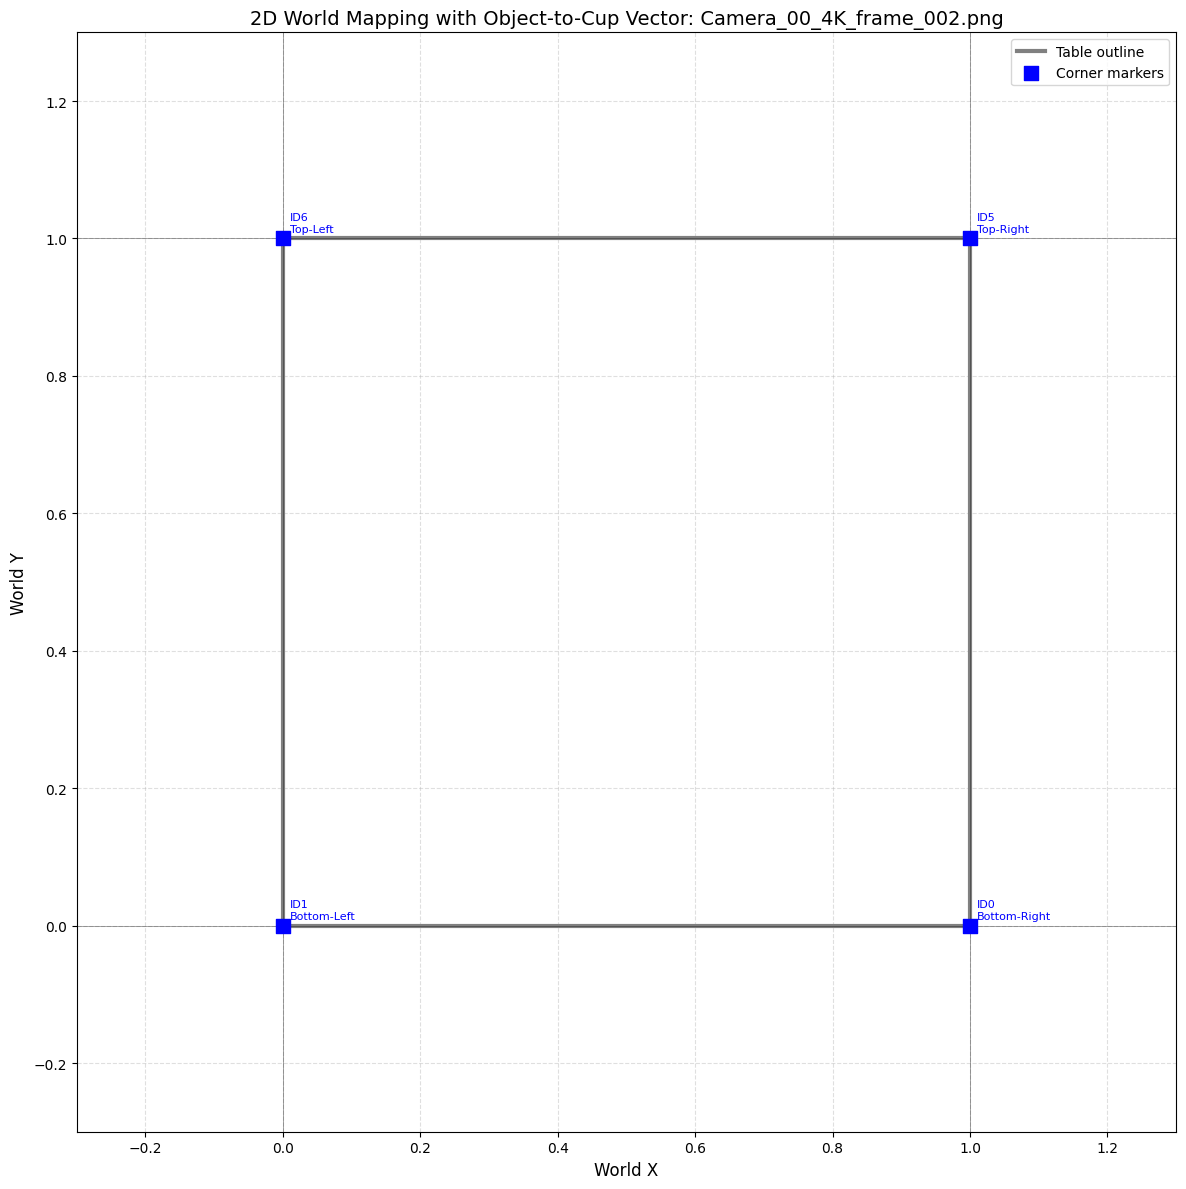


Processing: Camera_01_4K_frame_002.png
  Warning - missing target markers: [37, 38, 39]

  Corner markers:
    Top-Left    : Marker  0 at (1247.2,  268.5) -> world (0.0, 1.0)
    Top-Right   : Marker  1 at (2600.2,  815.5) -> world (1.0, 1.0)
    Bottom-Right: Marker  6 at (1989.0, 1863.2) -> world (1.0, 0.0)
    Bottom-Left : Marker  5 at ( 290.8,  904.0) -> world (0.0, 0.0)

  Target markers:


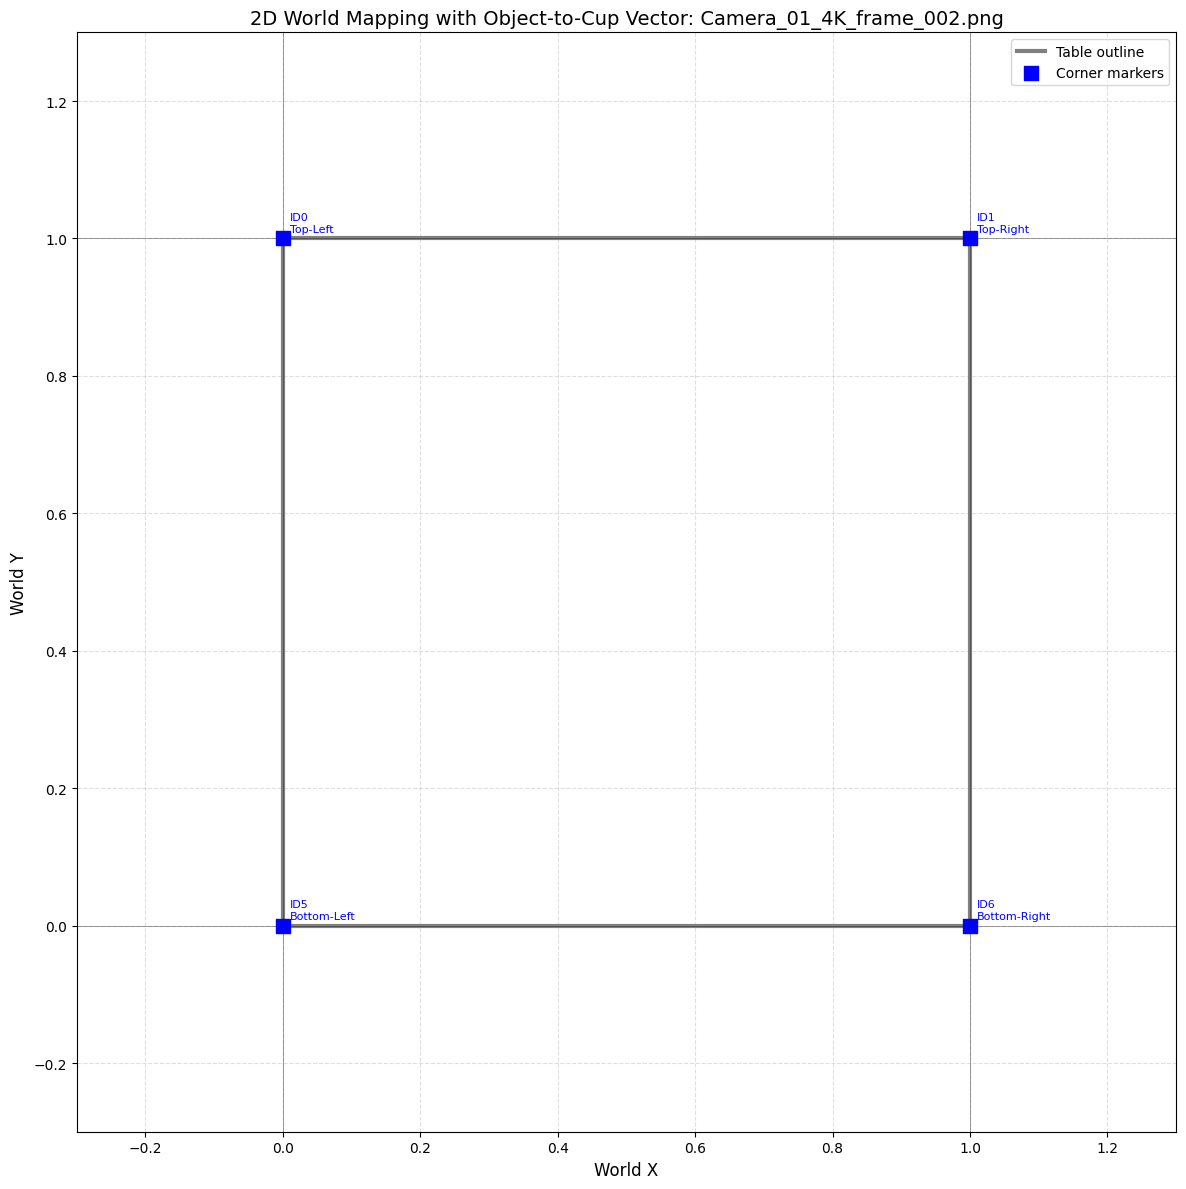


Processing: Camera_02_4K_frame_002.png
  Warning - missing target markers: [37, 38, 39]

  Corner markers:
    Top-Left    : Marker  1 at (1071.5,  443.2) -> world (0.0, 1.0)
    Top-Right   : Marker  6 at (1987.8,  183.8) -> world (1.0, 1.0)
    Bottom-Right: Marker  5 at (3116.8,  904.0) -> world (1.0, 0.0)
    Bottom-Left : Marker  0 at (2196.5, 1582.8) -> world (0.0, 0.0)

  Target markers:


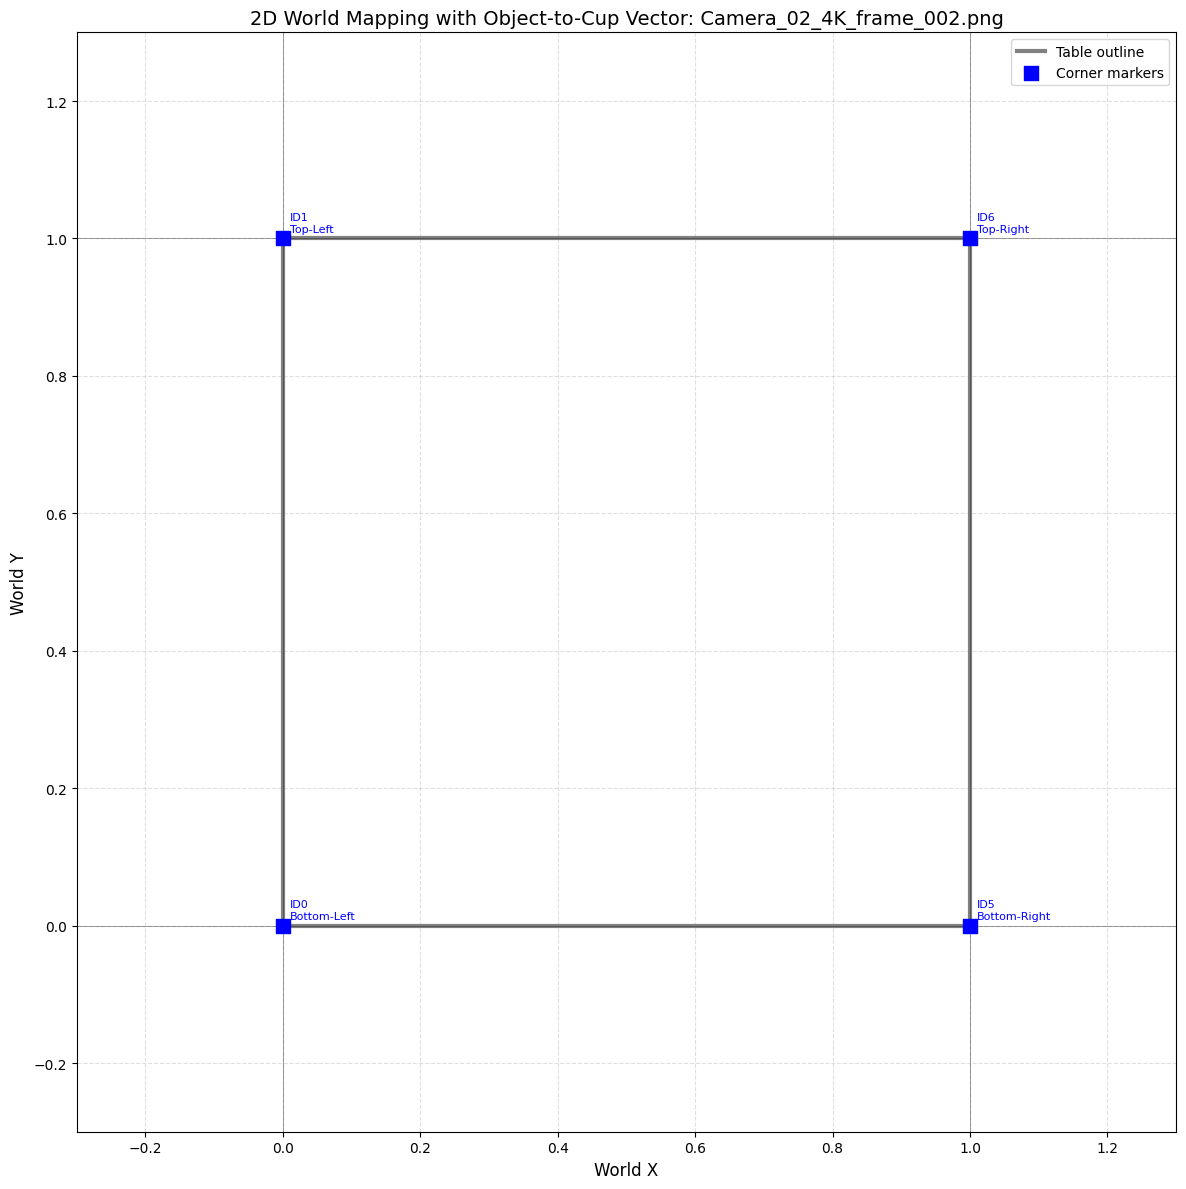


SUMMARY: Successfully processed 3 images

Saved world mapping results to: world_mapping_with_vectors.json


In [ ]:
# Storage for world coordinates
all_world_estimates = {marker_id: [] for marker_id in TARGET_MARKER_IDS}
all_cup_world_positions = []
all_cup_world_data = []
all_object_to_cup_data = []  # Store object-to-cup relationships
processed_count = 0

for img_name, detection_data in all_detection_data.items():
    print(f"\n{'=' * 60}")
    print(f"Processing: {img_name}")
    print("=" * 60)

    # Extract markers and cup data
    markers = detection_data.get("markers", {})
    cup_data = detection_data.get("cup", None)

    # Convert marker IDs to integers
    markers = {int(k): v for k, v in markers.items()}

    missing_corners = [mid for mid in CORNER_MARKER_IDS if mid not in markers]
    missing_targets = [mid for mid in TARGET_MARKER_IDS if mid not in markers]

    if missing_corners:
        print(f"  SKIPPING - missing corner markers: {missing_corners}")
        continue

    if missing_targets:
        print(f"  Warning - missing target markers: {missing_targets}")

    ordered_corners = auto_detect_corner_order(markers)
    if ordered_corners is None:
        print("  Could not determine corner order")
        continue

    print("\n  Corner markers:")

    corner_centers = []

    for i, (x, y, marker_id) in enumerate(ordered_corners):
        corner_centers.append((x, y))
        world_pos = WORLD_ANCHOR_POINTS[i]
        print(
            f"    {corner_labels[i]:12}: Marker {marker_id:2d} at ({x:6.1f}, {y:6.1f}) -> world {world_pos}"
        )

    # Compute homography
    H, _ = cv2.findHomography(np.array(corner_centers), np.array(WORLD_ANCHOR_POINTS))
    if H is None:
        print("  Could not compute homography")
        continue

    processed_count += 1

    # Process target markers
    current_image_targets = {}
    print("\n  Target markers:")

    for marker_id in TARGET_MARKER_IDS:
        if marker_id in markers:
            center = tuple(markers[marker_id]["center"])
            world_pos = project_point(H, center)
            all_world_estimates[marker_id].append(world_pos)
            current_image_targets[marker_id] = world_pos

            x, y = world_pos
            status = "Inside" if (0 <= x <= 1 and 0 <= y <= 1) else "Outside"
            print(
                f"    Marker {marker_id}: image({center[0]:6.1f}, {center[1]:6.1f}) -> world({x:.3f}, {y:.3f}) [{status}]"
            )

    # Process cup detection
    cup_world_pos = None
    if cup_data is not None:
        cup_center = tuple(cup_data["center"])
        cup_world_pos = project_point(H, cup_center)
        cup_confidence = cup_data.get("confidence", 0)

        all_cup_world_positions.append(cup_world_pos)
        all_cup_world_data.append(
            {
                "image": img_name,
                "world_pos": cup_world_pos,
                "image_pos": cup_center,
                "confidence": cup_confidence,
            }
        )

        x, y = cup_world_pos
        status = "Inside" if (0 <= x <= 1 and 0 <= y <= 1) else "Outside"
        print("\n  Cup detection:")
        print(f"    Image position: ({cup_center[0]:6.1f}, {cup_center[1]:6.1f})")
        print(f"    World position: ({x:.3f}, {y:.3f}) [{status}]")
        print(f"    Confidence: {cup_confidence:.2%}")

    # Calculate triangle data and object-to-cup relationship
    triangle_data = None
    object_to_cup_data = None

    if all([mid in current_image_targets for mid in TARGET_MARKER_IDS]):
        pos_37 = current_image_targets[37]
        pos_38 = current_image_targets[38]
        pos_39 = current_image_targets[39]

        # Calculate triangle centroid
        centroid_x = (pos_37[0] + pos_38[0] + pos_39[0]) / 3
        centroid_y = (pos_37[1] + pos_38[1] + pos_39[1]) / 3
        centroid = (centroid_x, centroid_y)

        # Original object direction (towards marker 39)
        direction_x = pos_39[0] - centroid_x
        direction_y = pos_39[1] - centroid_y

        magnitude = np.sqrt(direction_x**2 + direction_y**2)
        if magnitude > 0:
            unit_direction = (direction_x / magnitude, direction_y / magnitude)
        else:
            unit_direction = (0, 0)

        angle_rad = np.arctan2(direction_y, direction_x)
        angle_deg = np.degrees(angle_rad)

        triangle_data = {
            "image": img_name,
            "centroid": centroid,
            "direction": unit_direction,
            "angle_degrees": angle_deg,
        }

        print("\n  Triangle object:")
        print(f"    Centroid: ({centroid_x:.3f}, {centroid_y:.3f})")
        print(
            f"    Direction (to M39): ({unit_direction[0]:.3f}, {unit_direction[1]:.3f})"
        )
        print(f"    Angle (to M39): {angle_deg:.1f}°")

        # Calculate object-to-cup vector if cup is detected
        if cup_world_pos:
            cup_angle, cup_direction, distance = calculate_angle_and_direction(
                centroid, cup_world_pos
            )

            object_to_cup_data = {
                "image": img_name,
                "object_pos": centroid,
                "cup_pos": cup_world_pos,
                "direction_to_cup": cup_direction,
                "angle_to_cup": cup_angle,
                "distance": distance,
            }

            all_object_to_cup_data.append(object_to_cup_data)

            print("\n  Object-to-Cup vector:")
            print(
                f"    Direction to cup: ({cup_direction[0]:.3f}, {cup_direction[1]:.3f})"
            )
            print(f"    Angle to cup: {cup_angle:.1f}°")
            print(f"    Distance to cup: {distance:.3f}")

            # Calculate angle difference between object orientation and cup direction
            angle_diff = cup_angle - angle_deg
            # Normalize to [-180, 180]
            while angle_diff > 180:
                angle_diff -= 360
            while angle_diff < -180:
                angle_diff += 360
            print(f"    Rotation needed: {angle_diff:.1f}° (from current orientation)")

    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 12))

    # Draw table outline
    pts = np.array(WORLD_ANCHOR_POINTS, dtype=float)
    closed = np.vstack([pts, pts[0]])
    ax.plot(
        closed[:, 0], closed[:, 1], linewidth=3, color="gray", label="Table outline"
    )
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        s=100,
        color="blue",
        marker="s",
        label="Corner markers",
        zorder=5,
    )

    # Draw target markers
    for marker_id in TARGET_MARKER_IDS:
        if marker_id in current_image_targets:
            pos = current_image_targets[marker_id]
            ax.scatter(
                pos[0], pos[1], s=80, marker="^", label=f"Marker {marker_id}", zorder=6
            )
            ax.annotate(
                f"M{marker_id}",
                pos,
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
            )

    # Draw triangle object if all markers present
    if triangle_data:
        pos_37 = current_image_targets[37]
        pos_38 = current_image_targets[38]
        pos_39 = current_image_targets[39]

        # Draw triangle
        triangle = plt.Polygon(
            [pos_37, pos_38, pos_39],
            fill=False,
            edgecolor="green",
            linewidth=2,
            linestyle="--",
            alpha=0.7,
        )
        ax.add_patch(triangle)

        centroid_x, centroid_y = triangle_data["centroid"]
        unit_direction_x, unit_direction_y = triangle_data["direction"]

        # Draw centroid
        ax.scatter(
            centroid_x,
            centroid_y,
            s=200,
            marker="o",
            color="purple",
            label="Object position",
            zorder=7,
        )

        # Draw original direction arrow (towards marker 39)
        arrow_scale = 0.12
        ax.arrow(
            centroid_x,
            centroid_y,
            unit_direction_x * arrow_scale,
            unit_direction_y * arrow_scale,
            head_width=0.025,
            head_length=0.02,
            fc="purple",
            ec="purple",
            linewidth=2,
            zorder=8,
            alpha=0.7,
        )

        angle_deg = triangle_data["angle_degrees"]
        ax.annotate(
            f"Object\n({centroid_x:.2f}, {centroid_y:.2f})\nFacing: {angle_deg:.1f}°",
            (centroid_x, centroid_y),
            xytext=(-60, -40),
            textcoords="offset points",
            fontsize=9,
            color="purple",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Draw cup and object-to-cup vector
    if cup_world_pos:
        x, y = cup_world_pos

        # Draw cup position
        ax.scatter(
            x, y, s=300, marker="o", color="red", alpha=0.6, label="Cup", zorder=9
        )

        # Draw cup center point
        ax.scatter(x, y, s=50, marker="+", color="darkred", linewidth=2, zorder=10)

        # Add cup annotation
        confidence = cup_data.get("confidence", 0)
        ax.annotate(
            f"CUP\n({x:.2f}, {y:.2f})\n{confidence:.1%}",
            (x, y),
            xytext=(40, 20),
            textcoords="offset points",
            fontsize=10,
            color="red",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
            arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
        )

        # Draw object-to-cup vector if both exist
        if object_to_cup_data:
            centroid = object_to_cup_data["object_pos"]
            cup_direction = object_to_cup_data["direction_to_cup"]
            cup_angle = object_to_cup_data["angle_to_cup"]
            distance = object_to_cup_data["distance"]

            # Draw arrow from object to cup
            arrow_scale = min(0.2, distance * 0.8)  # Scale arrow based on distance
            ax.arrow(
                centroid[0],
                centroid[1],
                cup_direction[0] * arrow_scale,
                cup_direction[1] * arrow_scale,
                head_width=0.03,
                head_length=0.025,
                fc="orange",
                ec="orange",
                linewidth=3,
                zorder=8,
                alpha=0.9,
                label="Direction to Cup",
            )

            # Draw dashed line to actual cup position
            ax.plot(
                [centroid[0], x],
                [centroid[1], y],
                "orange",
                linestyle="--",
                alpha=0.4,
                linewidth=1.5,
            )

            # Add angle arc to show rotation from object orientation to cup
            if triangle_data:
                obj_angle = triangle_data["angle_degrees"]

                # Draw arc showing angle difference
                arc_radius = 0.08
                angle1 = min(obj_angle, cup_angle)
                angle2 = max(obj_angle, cup_angle)

                # Create arc
                if abs(angle2 - angle1) < 180:
                    angles = np.linspace(np.radians(angle1), np.radians(angle2), 20)
                else:
                    angles = np.linspace(
                        np.radians(angle2), np.radians(angle1 + 360), 20
                    )

                arc_x = centroid[0] + arc_radius * np.cos(angles)
                arc_y = centroid[1] + arc_radius * np.sin(angles)
                ax.plot(arc_x, arc_y, "orange", linewidth=1.5, alpha=0.7)

            # Annotate the object-to-cup information
            mid_x = centroid[0] + cup_direction[0] * arrow_scale * 1.5
            mid_y = centroid[1] + cup_direction[1] * arrow_scale * 1.5

            angle_diff = (
                cup_angle - triangle_data["angle_degrees"] if triangle_data else 0
            )
            while angle_diff > 180:
                angle_diff -= 360
            while angle_diff < -180:
                angle_diff += 360

            ax.annotate(
                f"To Cup:\n{cup_angle:.1f}°\nDist: {distance:.2f}\nTurn: {angle_diff:+.1f}°",
                (mid_x, mid_y),
                fontsize=9,
                color="orange",
                fontweight="bold",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
            )

    # Annotate corners
    for i, (corner_x, corner_y) in enumerate(WORLD_ANCHOR_POINTS):
        detected_marker_id = ordered_corners[i][2]
        ax.annotate(
            f"ID{detected_marker_id}\n{corner_labels[i]}",
            (corner_x, corner_y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            color="blue",
        )

    # Set plot properties
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 1.3)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("World X", fontsize=12)
    ax.set_ylabel("World Y", fontsize=12)
    ax.set_title(f"2D World Mapping with Object-to-Cup Vector: {img_name}", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.4)

    # Add grid lines at boundaries
    ax.axhline(y=0, color="k", linestyle="-", linewidth=0.5, alpha=0.5)
    ax.axvline(x=0, color="k", linestyle="-", linewidth=0.5, alpha=0.5)
    ax.axhline(y=1, color="k", linestyle="-", linewidth=0.5, alpha=0.5)
    ax.axvline(x=1, color="k", linestyle="-", linewidth=0.5, alpha=0.5)

    ax.legend(loc="best", fontsize=10)
    plt.tight_layout()
    plt.show()

# Summary
print(f"\n{'=' * 60}")
print(f"SUMMARY: Successfully processed {processed_count} images")
print("=" * 60)

# Object-to-Cup relationship summary
if all_object_to_cup_data:
    print("\nOBJECT-TO-CUP ANALYSIS:")
    print(f"  Found {len(all_object_to_cup_data)} images with both object and cup")

    distances = [d["distance"] for d in all_object_to_cup_data]
    angles = [d["angle_to_cup"] for d in all_object_to_cup_data]

    print("\n  Distance statistics:")
    print(f"    Average distance: {np.mean(distances):.3f}")
    print(f"    Min distance: {min(distances):.3f}")
    print(f"    Max distance: {max(distances):.3f}")
    print(f"    Std deviation: {np.std(distances):.3f}")

    print("\n  Angle statistics:")
    print(f"    Average angle to cup: {np.mean(angles):.1f}°")
    print(f"    Angle range: {min(angles):.1f}° to {max(angles):.1f}°")

    print("\n  Individual measurements:")
    for data in all_object_to_cup_data:
        print(
            f"    {data['image']:20s}: Angle={data['angle_to_cup']:6.1f}°, Distance={data['distance']:.3f}"
        )

# Cup position summary
if all_cup_world_positions:
    print("\nCUP DETECTION SUMMARY:")
    print(f"  Cups detected in {len(all_cup_world_positions)} images")

    xs = [p[0] for p in all_cup_world_positions]
    ys = [p[1] for p in all_cup_world_positions]

    avg_x, avg_y = np.mean(xs), np.mean(ys)
    std_x, std_y = np.std(xs), np.std(ys)

    print(f"  Average position: ({avg_x:.3f}, {avg_y:.3f})")
    print(f"  Std deviation: x={std_x:.3f}, y={std_y:.3f}")

    inside_count = sum(
        1 for x, y in all_cup_world_positions if 0 <= x <= 1 and 0 <= y <= 1
    )
    print(f"  Inside table: {inside_count}/{len(all_cup_world_positions)} detections")

# Save all world mapping data
output_data = {
    "corner_marker_ids": CORNER_MARKER_IDS,
    "target_marker_ids": TARGET_MARKER_IDS,
    "world_anchor_points": WORLD_ANCHOR_POINTS,
    "cup_world_positions": all_cup_world_data,
    "object_to_cup_vectors": all_object_to_cup_data,
    "processed_images": processed_count,
}

with open("world_mapping_with_vectors.json", "w") as f:
    json.dump(output_data, f, indent=2)

print("\nSaved world mapping results to: world_mapping_with_vectors.json")


Processing: Camera_00_4K_frame_002.png

  Corner markers:
    Top-Left    : Marker  6 at ( 977.0,  877.2) -> world (0.0, 1.0)
    Top-Right   : Marker  5 at (2263.0,  521.5) -> world (1.0, 1.0)
    Bottom-Right: Marker  0 at (3028.5, 1154.8) -> world (1.0, 0.0)
    Bottom-Left : Marker  1 at (1531.5, 1946.2) -> world (0.0, 0.0)

  Robodog detection:
    World position: (0.829, 0.471) [Inside]
    Fixed Angle: -90.0°

  Human detection:
    World position: (0.189, 0.989) [Inside]

  Robodog-to-Human vector:
    Direction to human: (-0.777, 0.629)
    Angle to human: 141.0°
    Distance: 0.823
    Rotation needed: -129.0° (from current orientation)


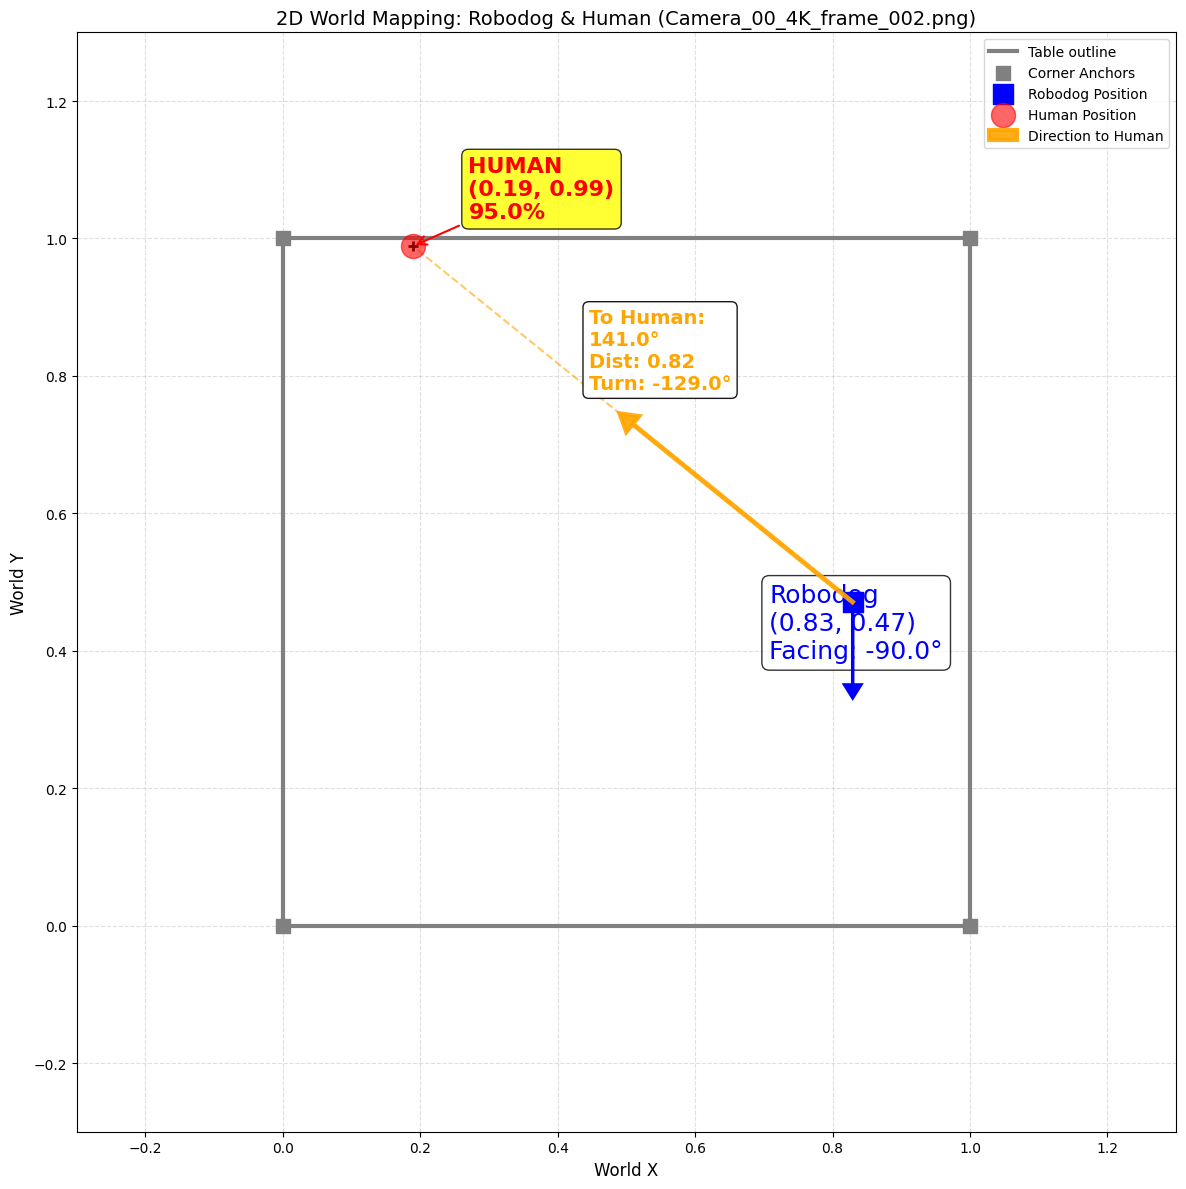


Processing: Camera_01_4K_frame_002.png

  Corner markers:
    Top-Left    : Marker  0 at (1247.2,  268.5) -> world (0.0, 1.0)
    Top-Right   : Marker  1 at (2600.2,  815.5) -> world (1.0, 1.0)
    Bottom-Right: Marker  6 at (1989.0, 1863.2) -> world (1.0, 0.0)
    Bottom-Left : Marker  5 at ( 290.8,  904.0) -> world (0.0, 0.0)

  Robodog detection:
    World position: (0.172, 0.675) [Inside]
    Fixed Angle: -90.0°

  Human detection:
    World position: (0.816, 0.538) [Inside]

  Robodog-to-Human vector:
    Direction to human: (0.978, -0.209)
    Angle to human: -12.0°
    Distance: 0.659
    Rotation needed: 78.0° (from current orientation)


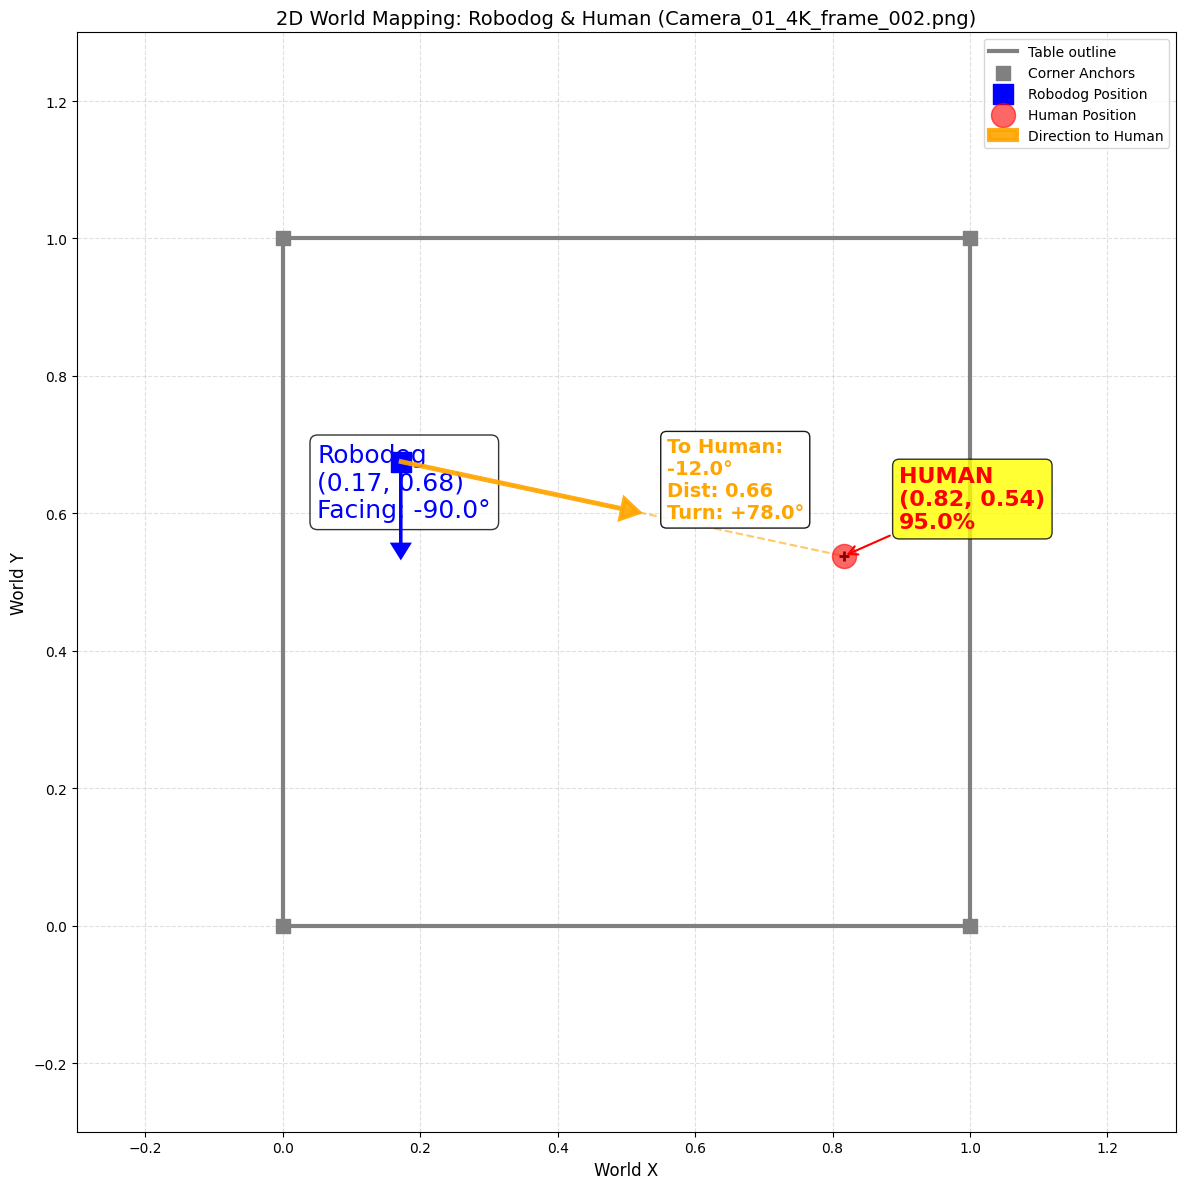


Processing: Camera_02_4K_frame_002.png

  Corner markers:
    Top-Left    : Marker  1 at (1071.5,  443.2) -> world (0.0, 1.0)
    Top-Right   : Marker  6 at (1987.8,  183.8) -> world (1.0, 1.0)
    Bottom-Right: Marker  5 at (3116.8,  904.0) -> world (1.0, 0.0)
    Bottom-Left : Marker  0 at (2196.5, 1582.8) -> world (0.0, 0.0)

  Robodog detection:
    World position: (0.517, 0.277) [Inside]
    Fixed Angle: -90.0°

  Human detection:
    World position: (0.300, 1.138) [Outside]

  Robodog-to-Human vector:
    Direction to human: (-0.244, 0.970)
    Angle to human: 104.1°
    Distance: 0.888
    Rotation needed: -165.9° (from current orientation)


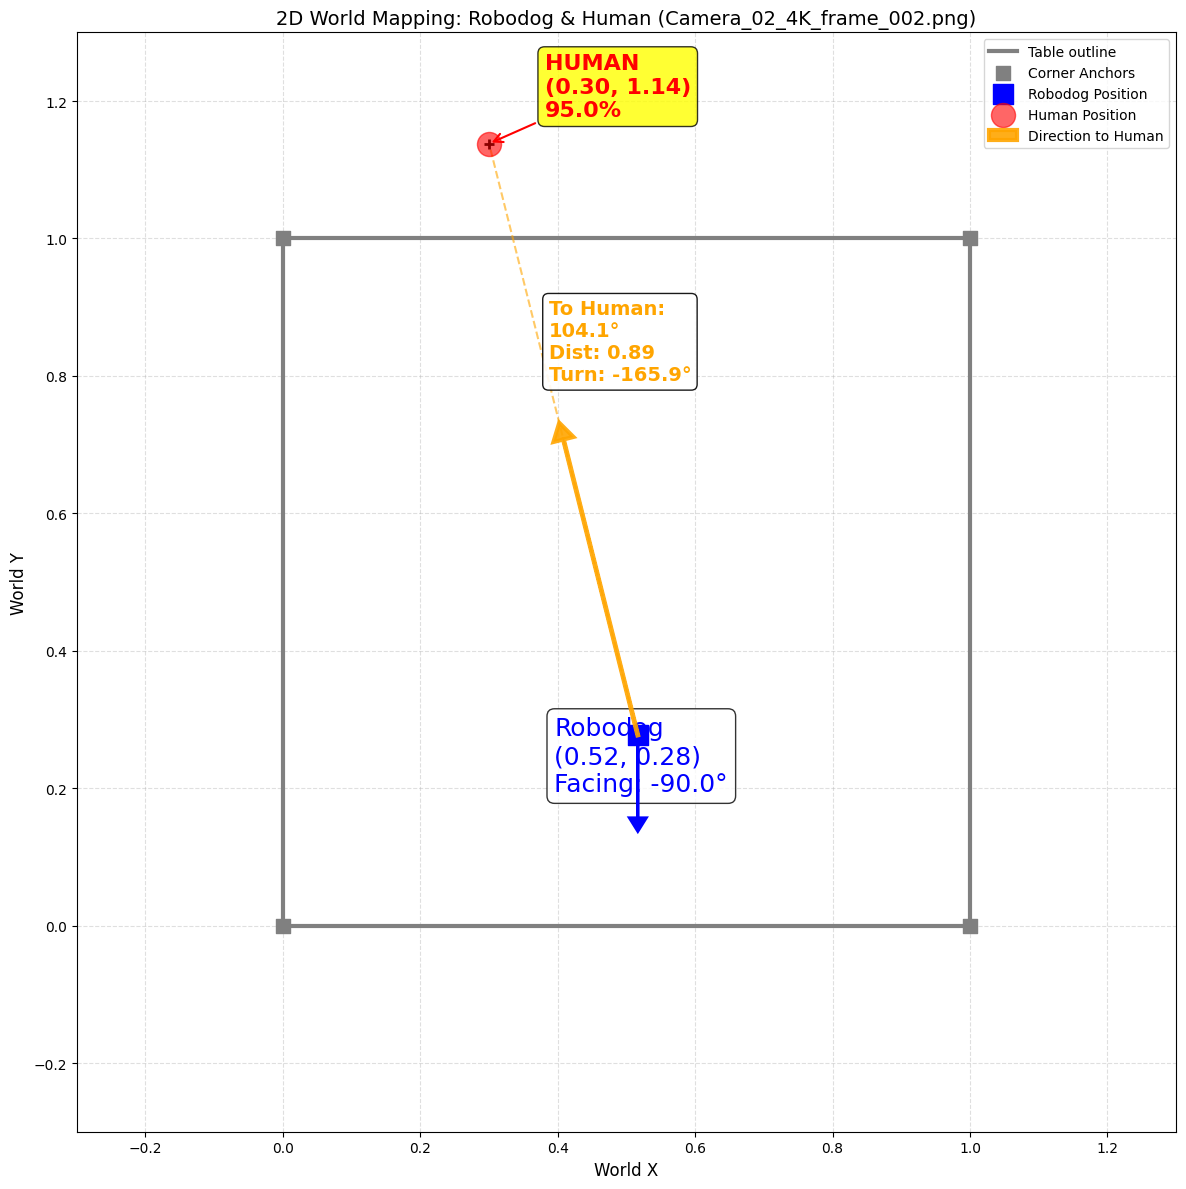


SUMMARY: Successfully processed 3 images

ROBODOG-TO-HUMAN ANALYSIS:
  Average distance: 0.790 (std: 0.096)

Saved world mapping results to: world_mapping_results.json


In [44]:
# ==============================================================================
# MODIFIED SCRIPT STARTS HERE
# ==============================================================================

# Storage for world coordinates
all_robodog_world_data = []
all_human_world_data = []
all_robodog_to_human_data = []  # Store robodog-to-human relationships
processed_count = 0

for img_name, detection_data in all_detection_data.items():
    print(f"\n{'=' * 60}")
    print(f"Processing: {img_name}")
    print("=" * 60)

    # --- MODIFIED: Extract robodog and human data instead of markers and cup ---
    markers = detection_data.get("markers", {})
    robodog_data = detection_data.get("robodog", None)
    human_data = detection_data.get("human / mannequin", None)

    # Convert marker IDs to integers
    markers = {int(k): v for k, v in markers.items()}

    missing_corners = [mid for mid in CORNER_MARKER_IDS if mid not in markers]
    if missing_corners:
        print(f"  SKIPPING - missing corner markers: {missing_corners}")
        continue

    ordered_corners = auto_detect_corner_order(markers)
    if ordered_corners is None:
        print("  Could not determine corner order")
        continue

    print("\n  Corner markers:")
    corner_labels = ["Top-Left", "Top-Right", "Bottom-Right", "Bottom-Left"]
    corner_centers = []

    for i, (x, y, marker_id) in enumerate(ordered_corners):
        corner_centers.append((x, y))
        world_pos = WORLD_ANCHOR_POINTS[i]
        print(
            f"    {corner_labels[i]:12}: Marker {marker_id:2d} at ({x:6.1f}, {y:6.1f}) -> world {world_pos}"
        )

    # Compute homography
    H, _ = cv2.findHomography(np.array(corner_centers), np.array(WORLD_ANCHOR_POINTS))
    if H is None:
        print("  Could not compute homography")
        continue

    processed_count += 1

    # --- NEW: Process Robodog detection ---
    robodog_world_data = None
    robodog_world_pos = None
    if robodog_data is not None:
        robodog_center = tuple(robodog_data["center"])
        robodog_world_pos = project_point(H, robodog_center)
        confidence = robodog_data.get("confidence", 0)

        # Define fixed orientation for robodog (upwards in world space)
        # Assuming Y points down, "up" is (0, -1) vector, which is -90 degrees
        robodog_direction = (0, -1)
        robodog_angle_deg = -90.0

        robodog_world_data = {
            "image": img_name,
            "world_pos": robodog_world_pos,
            "direction": robodog_direction,
            "angle_degrees": robodog_angle_deg,
            "confidence": confidence,
        }
        all_robodog_world_data.append(robodog_world_data)

        x, y = robodog_world_pos
        status = "Inside" if (0 <= x <= 1 and 0 <= y <= 1) else "Outside"
        print("\n  Robodog detection:")
        print(f"    World position: ({x:.3f}, {y:.3f}) [{status}]")
        print(f"    Fixed Angle: {robodog_angle_deg:.1f}°")

    # --- MODIFIED: Process Human detection (formerly cup) ---
    human_world_pos = None
    if human_data is not None:
        human_center = tuple(human_data["center"])
        human_world_pos = project_point(H, human_center)
        confidence = human_data.get("confidence", 0)

        all_human_world_data.append(
            {"image": img_name, "world_pos": human_world_pos, "confidence": confidence}
        )

        x, y = human_world_pos
        status = "Inside" if (0 <= x <= 1 and 0 <= y <= 1) else "Outside"
        print("\n  Human detection:")
        print(f"    World position: ({x:.3f}, {y:.3f}) [{status}]")

    # --- MODIFIED: Calculate Robodog-to-Human relationship ---
    robodog_to_human_data = None
    if robodog_world_pos and human_world_pos:
        human_angle, human_direction, distance = calculate_angle_and_direction(
            robodog_world_pos, human_world_pos
        )

        robodog_to_human_data = {
            "image": img_name,
            "robodog_pos": robodog_world_pos,
            "human_pos": human_world_pos,
            "direction_to_human": human_direction,
            "angle_to_human": human_angle,
            "distance": distance,
        }
        all_robodog_to_human_data.append(robodog_to_human_data)

        print("\n  Robodog-to-Human vector:")
        print(
            f"    Direction to human: ({human_direction[0]:.3f}, {human_direction[1]:.3f})"
        )
        print(f"    Angle to human: {human_angle:.1f}°")
        print(f"    Distance: {distance:.3f}")

        # Calculate angle difference
        angle_diff = human_angle - robodog_angle_deg
        angle_diff = (angle_diff + 180) % 360 - 180  # Normalize to [-180, 180]
        print(f"    Rotation needed: {angle_diff:.1f}° (from current orientation)")

    # --- VISUALIZATION UPDATED ---
    fig, ax = plt.subplots(figsize=(12, 12))

    # Draw table outline
    pts = np.array(WORLD_ANCHOR_POINTS, dtype=float)
    closed = np.vstack([pts, pts[0]])
    ax.plot(
        closed[:, 0], closed[:, 1], linewidth=3, color="gray", label="Table outline"
    )
    ax.scatter(
        pts[:, 0],
        pts[:, 1],
        s=100,
        color="gray",
        marker="s",
        label="Corner Anchors",
        zorder=5,
    )

    # Draw Robodog
    if robodog_world_data:
        pos = robodog_world_data["world_pos"]
        direction = robodog_world_data["direction"]
        angle = robodog_world_data["angle_degrees"]

        ax.scatter(
            pos[0],
            pos[1],
            s=200,
            marker="s",
            color="blue",
            label="Robodog Position",
            zorder=7,
        )

        arrow_scale = 0.12
        ax.arrow(
            pos[0],
            pos[1],
            direction[0] * arrow_scale,
            direction[1] * arrow_scale,
            head_width=0.025,
            head_length=0.02,
            fc="blue",
            ec="blue",
            linewidth=2,
            zorder=8,
        )

        ax.annotate(
            f"Robodog\n({pos[0]:.2f}, {pos[1]:.2f})\nFacing: {angle:.1f}°",
            (pos[0], pos[1]),
            xytext=(-60, -40),
            textcoords="offset points",
            fontsize=18,
            color="blue",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Draw Human
    if human_world_pos:
        x, y = human_world_pos
        ax.scatter(
            x,
            y,
            s=300,
            marker="o",
            color="red",
            alpha=0.6,
            label="Human Position",
            zorder=9,
        )
        ax.scatter(x, y, s=50, marker="+", color="darkred", linewidth=2, zorder=10)
        confidence = human_data.get("confidence", 0)
        ax.annotate(
            f"HUMAN\n({x:.2f}, {y:.2f})\n{confidence:.1%}",
            (x, y),
            xytext=(40, 20),
            textcoords="offset points",
            fontsize=16,
            color="red",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
            arrowprops=dict(arrowstyle="->", color="red", lw=1.5),
        )

    # Draw Robodog-to-Human vector
    if robodog_to_human_data:
        robodog_pos = robodog_to_human_data["robodog_pos"]
        human_pos = robodog_to_human_data["human_pos"]
        human_dir = robodog_to_human_data["direction_to_human"]
        human_angle = robodog_to_human_data["angle_to_human"]
        distance = robodog_to_human_data["distance"]

        # Draw arrow from robodog towards human
        ax.plot(
            [robodog_pos[0], human_pos[0]],
            [robodog_pos[1], human_pos[1]],
            "orange",
            linestyle="--",
            alpha=0.6,
            linewidth=1.5,
        )

        ax.arrow(
            robodog_pos[0],
            robodog_pos[1],
            human_dir[0] * distance * 0.5,
            human_dir[1] * distance * 0.5,
            head_width=0.03,
            head_length=0.025,
            fc="orange",
            ec="orange",
            linewidth=3,
            zorder=8,
            alpha=0.9,
            label="Direction to Human",
        )

        # Calculate and display rotation
        angle_diff = human_angle - robodog_angle_deg
        angle_diff = (angle_diff + 180) % 360 - 180

        mid_x = robodog_pos[0] + human_dir[0] * distance * 0.6
        mid_y = robodog_pos[1] + human_dir[1] * distance * 0.6
        ax.annotate(
            f"To Human:\n{human_angle:.1f}°\nDist: {distance:.2f}\nTurn: {angle_diff:+.1f}°",
            (mid_x, mid_y),
            fontsize=14,
            color="orange",
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
        )

    # Plot settings
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 1.3)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("World X", fontsize=12)
    ax.set_ylabel("World Y", fontsize=12)
    ax.set_title(f"2D World Mapping: Robodog & Human ({img_name})", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="best", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"world_mapping_robodog_human_{img_name}.png", transparent=True)
    plt.show()

# --- SUMMARY UPDATED ---
print(f"\n{'=' * 60}")
print(f"SUMMARY: Successfully processed {processed_count} images")
print("=" * 60)

if all_robodog_to_human_data:
    print("\nROBODOG-TO-HUMAN ANALYSIS:")
    distances = [d["distance"] for d in all_robodog_to_human_data]
    print(
        f"  Average distance: {np.mean(distances):.3f} (std: {np.std(distances):.3f})"
    )

# Final data dump
output_data = {
    "corner_marker_ids": CORNER_MARKER_IDS,
    "world_anchor_points": WORLD_ANCHOR_POINTS,
    "robodog_data": all_robodog_world_data,
    "human_data": all_human_world_data,
    "robodog_to_human_vectors": all_robodog_to_human_data,
    "processed_images": processed_count,
}

with open("world_mapping_results.json", "w") as f:
    json.dump(output_data, f, indent=2)

print("\nSaved world mapping results to: world_mapping_results.json")

### put bboxes and aruco markers info together on a plane